In [1]:
import numpy as np
import pandas as pd
import seaborn as sns


import csv

import os 
import sklearn
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import cohen_kappa_score

from statsmodels.stats.inter_rater import fleiss_kappa

In [2]:
data_multi = pd.read_feather('/home/rbarreto/data/scaled-facets-multi-50k-v4.feather')
data_multi.head(5)

,sentiment,respect,insult,humiliate,status,dehumanize,violence_phys,genocide,attack_defend,hatespeech,...,demo_sexual_orien_2,demo_sexual_orien_3,demo_sexual_orien_4,demo_sexual_orien_5,demo_sexual_orien_4_text,demo_ideology,locationlatitude,locationlongitude,identity,hypothesis
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,,4.0,37.55029296875,-77.39420318603515625,0.917681,-1.130178
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,,4.0,32.9568939208984375,-96.83170318603515625,0.918119,-1.146973
2,4.0,4.0,3.0,2.0,1.0,1.0,0.0,0.0,3.0,1.0,...,NaN,NaN,NaN,NaN,,5.0,39.3361053466796875,-76.53890228271484375,0.985910,-0.207369
3,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,,4.0,37.1439971923828125,-94.4727020263671875,0.969761,-0.055536
4,4.0,4.0,3.0,2.0,1.0,1.0,1.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,,4.0,34.215301513671875,-79.64679718017578125,0.935462,0.104225


In [19]:
len(data_multi)

135556

In [12]:
#let's look at how many black labelers there are for black content

len(data_multi[data_multi['target_race_1'] == 1])



22899

In [17]:
len(data_multi[(data_multi['target_race_1'] == 1) & (data_multi['demo_race_ethnicitie_3'])])

2292

In [18]:
#let's look at how many white labelers there are for black content 

len(data_multi[(data_multi['target_race_1'] == 1) & (data_multi['demo_race_ethnicitie_6'])])

18545

In [20]:
#let's look at how many datapoints target women 

len(data_multi[data_multi['target_gender_3'] == 1])

27889

In [23]:
data_multi['demo_gender'].value_counts()
#1 = female
#2 = male

1.0    76370
2.0    57582
3.0      985
5.0      500
4.0      119
Name: demo_gender, dtype: int64

In [25]:
#let's look at how many men labelers tehre are for content targeting owmen 


#let's look at how many women labelers there are for content targeting women 
len(data_multi[(data_multi['target_gender_3'] == 1) & (data_multi['demo_gender'] == 2)])

11854

In [24]:

#let's look at how many women labelers there are for content targeting women 
len(data_multi[(data_multi['target_gender_3'] == 1) & (data_multi['demo_gender'] == 1)])


15703

In [ ]:
#so we know that there isn't a discrepancy in terms of numbers here -- this is interesting bc we could see what happens when mainly women label 
#content targeting women to the severity scores, which like Pratik said are dependent on the majority in order to establish a base line of what is 
#severe / leneient 


In [33]:
#how much data is targeting trans people 
len(data_multi[(data_multi['target_gender_2'] == 1) | (data_multi['target_gender_5'] == 1) | 
           (data_multi['target_gender_6'] == 1) | (data_multi['target_gender_7'] == 1) |
           (data_multi['target_gender_4'] == 1)])

7918

In [39]:
#actually looking at the text and the sentiment that was assinged for content targeting trans folks
data_multi[(data_multi['target_gender_2'] == 1) | (data_multi['target_gender_5'] == 1) | 
           (data_multi['target_gender_6'] == 1) | (data_multi['target_gender_7'] == 1) |
           (data_multi['target_gender_4'] == 1)][['predict_text', 'sentiment']]

,predict_text,sentiment
1,The trans women reading this tweet right now i...,0.0
29,Them - DON'T YOU DARE OBJECTIFY US!! ​ Also th...,3.0
38,At this point joe is a [SLUR] retard that care...,4.0
53,Are you attractive? Do you have a strong frame...,3.0
65,Counterpoint: almost no one is actually afraid...,3.0
...,...,...
135537,I love that you enjoy being trans.,1.0
135538,"Please help support nonbinary pride, add a #Tw...",2.0
135539,Trans rights are human rights,0.0
135541,I love that you enjoy being trans.,0.0


In [42]:
#this is how much content was labeled by trans labelers  - do we have to do like nunique or something here?
len(data_multi[data_multi['demo_trans'] == 1])
#yes is 1 
#no is 2 
#prefer not to say is 4

#total number of data 135556

1183

In [3]:
#how many labelers do we have?

data_multi['labeler_id'].nunique()

7912

In [ ]:
pd.pivot_table(data_multi, values = 'labeler')

In [68]:
data_multi.groupby('labeler_id')[['labeler_id', 'demo_trans', 'demo_gender', 'demo_race_ethnicitie_1', 'demo_race_ethnicitie_2']].min()
#1 is female
#2 is male
#3 is non binary or third gender
#5 prefer not to say 
#prefer to self describe 

,labeler_id,demo_trans,demo_gender,demo_race_ethnicitie_1,demo_race_ethnicitie_2
labeler_id,,,,,
1,1,2.0,2.0,NaN,NaN
3,3,2.0,1.0,NaN,NaN
4,4,2.0,1.0,NaN,NaN
5,5,2.0,2.0,NaN,NaN
6,6,2.0,1.0,NaN,NaN
...,...,...,...,...,...
11138,11138,2.0,1.0,NaN,1.0
11139,11139,2.0,2.0,NaN,NaN
11140,11140,2.0,1.0,NaN,NaN


In [5]:
df = data_multi

In [6]:
df['full_race'] = ""


In [65]:
#American Indian or Alaska Native (1)
#Asian (2)
#Black or African American (3)
#Hispanic/Latino (4)
#Native Hawaiian or Pacific Islander (5)
#White (6)
#Other (7)
#Middle Eastern (8)

In [42]:
#then create a new column that's just an aggregate of the other column

def label_race(row):
    if (row['demo_race_ethnicitie_1'] + row['demo_race_ethnicitie_2'] + 
    row['demo_race_ethnicitie_3'] + row['demo_race_ethnicitie_4'] + 
    row['demo_race_ethnicitie_5'] + row['demo_race_ethnicitie_6'] + 
    row['demo_race_ethnicitie_7'] + row['demo_race_ethnicitie_8'] > 1):
        return 'two or more races'
    if row['demo_race_ethnicitie_1'] == 1:
        return 'american indian alaska native'
    if row['demo_race_ethnicitie_2'] == 1:
        return 'asian'
    if row['demo_race_ethnicitie_3'] == 1:
        return 'black'
    if row['demo_race_ethnicitie_4'] == 1:
        return 'latino'
    if row['demo_race_ethnicitie_5'] == 1:
        return 'native hawaiian pacific islander'
    if row['demo_race_ethnicitie_6'] == 1:
        return 'white'
    if row['demo_race_ethnicitie_7'] == 1:
        return 'other race'
    if row['demo_race_ethnicitie_8'] == 1:
        return 'middle eastern'
    return 'unknown'

#what's going to happen to the cases that are more than one bc they're not mutually exclusive (races)?
#tried to solve this through two or more races option


In [ ]:
for idx, row in df.iterrows():
    if (row['demo_race_ethnicitie_1'] + row['demo_race_ethnicitie_2']) == 

In [45]:
for idx, row in data_multi.iterrows():
    if (row['demo_race_ethnicitie_1'] + row['demo_race_ethnicitie_2'] + 
    row['demo_race_ethnicitie_3'] + row['demo_race_ethnicitie_4'] + 
    row['demo_race_ethnicitie_5'] + row['demo_race_ethnicitie_6'] + 
    row['demo_race_ethnicitie_7'] + row['demo_race_ethnicitie_8'] > 1):
        print('two or more')

In [47]:
for idx, row in data_multi.iterrows():
    if row['demo_race_ethnicitie_1'] + row['demo_race_ethnicitie_2'] + row['demo_race_ethnicitie_3'] + row['demo_race_ethnicitie_4'] + row['demo_race_ethnicitie_5'] + row['demo_race_ethnicitie_6'] + row['demo_race_ethnicitie_7'] + row['demo_race_ethnicitie_8'] > 1:
        print('two or more')

In [ ]:
# for idx, row in data_multi.iterrows():
#     if row['demo_race_ethnicitie_1'] + row['demo_race_ethnicitie_2'] > 1:
#         print(idx, 'two or more')

In [ ]:
# for idx, row in data_multi.iterrows():
#     if row['demo_race_ethnicitie_1'] + row['demo_race_ethnicitie_2'] + row['demo_race_ethnicitie_3'] > 1:
#         print(idx, 'two or more')

In [63]:
list_greater_1 = []
for idx, row in data_multi.iterrows():
    if np.array(row['demo_race_ethnicitie_1']) + np.array(row['demo_race_ethnicitie_2']) + np.array(row['demo_race_ethnicitie_3']) + np.array(row['demo_race_ethnicitie_4']) + np.array(row['demo_race_ethnicitie_5']) + np.array(row['demo_race_ethnicitie_6']) + np.array(row['demo_race_ethnicitie_7']) + np.array(row['demo_race_ethnicitie_8'] > 1:
        list_greater_1.append(sum_array)
   

SyntaxError: invalid syntax (<ipython-input-63-0f6360f982a0>, line 3)

In [ ]:
df['test_race'] = ''

In [43]:
#applying function to df
#making the NAs into 0 for the function above to work

#maybe this has to be inplace = true

df['full_race'] = df.replace('NA', 0).apply(label_race, axis=1) #axis =1 means application is done at row rather than column lelvel


In [44]:
df['full_race'].value_counts()

white                               100809
black                                12675
asian                                 9513
latino                                8466
american indian alaska native         2636
other race                             897
native hawaiian pacific islander       288
middle eastern                         215
unknown                                 57
Name: full_race, dtype: int64

In [37]:
df.groupby('labeler_id')['labeler_id', 'full_race'].max()['full_race'].value_counts(dropna=False)

<ipython-input-37-5ab5f658853b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('labeler_id')['labeler_id', 'full_race'].max()['full_race'].value_counts(dropna=False)


white                               5891
black                                736
asian                                547
latino                               499
american indian alaska native        154
other race                            50
native hawaiian pacific islander      17
middle eastern                        14
unknown                                4
Name: full_race, dtype: int64

<ipython-input-15-253bf42a484c>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('labeler_id')['labeler_id', 'demo_race_ethnicitie_1'].max()['demo_race_ethnicitie_1'].value_counts()


1.0    154
Name: demo_race_ethnicitie_1, dtype: int64

In [30]:
#the other option is to look at trans not trans which i think was what we were looking at before in the prevous notebooks

#the amount of content targeting trans people not labeled by trans people 

len(data_multi[(data_multi['target_gender_2'] == 1) | (data_multi['target_gender_5'] == 1) | 
           (data_multi['target_gender_6'] == 1) | (data_multi['target_gender_7'] == 1) |
           (data_multi['target_gender_4'] == 1) & (data_multi['demo_trans'] == 1)])


7372

In [ ]:
#create a visualization that shows these discrepancies 

In [ ]:
# #let's look at a particular comment

# ax = sns.countplot(x='race_label', data=df_comment_20012)

# labels = ['white', 'asian', 'black', 'latino', 'two or more races', 'american indian alaska native', 'other race', 'native hawaiian pacific islander', 'middle eastern', 'unknown']
          
# ax.set_xticklabels(labels)
# ax.set_ylabel('Number of Raters')
# ax.set_xlabel('Race')


# for name in ax.get_xticklabels(): #notsure what the get_xticklabels does, is it like getcolumnames 
#   name.set_rotation(75) 

In [ ]:
# 1 = 1

In [3]:
#this has a lot of dependencies and requires loading in a lot of data
#then plot the distribution of races (barplot) for a particular comment

ax = sns.countplot(x='race_label', data=df_comment_20007)

labels = ['white', 'asian', 'black', 'latino', 'two or more races', 'american indian alaska native', 'other race', 'native hawaiian pacific islander', 'middle eastern', 'unknown']
          
#ax.set_xticklabels(labels)
# ax.set_ylabel('Number of Raters')
# ax.set_xlabel('Race')


for name in ax.get_xticklabels(): #notsure what the get_xticklabels does, is it like getcolumnames 
    name.set_rotation(75) 



NameError: name 'df_comment_20007' is not defined

In [20]:
#number of comments targeting black folks (repeats included)
black_targets_all = len(data_multi[data_multi['target_race_1'] == 1]['comment_id'])

In [18]:
#for comments targeting black folks, how many black raters did we have?

black_labelers_black_targets = len(data_multi[(data_multi['target_race_1'] == 1) & (data_multi['demo_race_ethnicitie_3'] == 1)]['comment_id'])

In [19]:
#for comments targeting black folks, how many white raters did we have? 
white_labelers_black_targets = len(data_multi[(data_multi['target_race_1'] == 1) & (data_multi['demo_race_ethnicitie_6'] == 1)]['comment_id'])

In [22]:
#percentage white labelers black content 
white_labelers_black_targets / black_targets_all * 100

80.9860692606664

In [23]:
#percentage black labelers black content
black_labelers_black_targets / black_targets_all * 100 

10.009170706144372

In [24]:
#so what does this actually mean in practice? 

#this is why the measurement part matters bc maybe they'll (the labelers) all agree yes it's bad
#but how bad is it? 
#and ths could then influence things like borderline content 
#tease this out some mocre

construct = ['sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence_phys', 'genocide', 'attack_defend', 'hatespeech']

In [30]:
data_multi[data_multi['comment_id'] == 305][['comment_id', 'predict_text','sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence_phys', 'genocide', 'attack_defend', 'hatespeech' ]]

,comment_id,predict_text,sentiment,respect,insult,humiliate,status,dehumanize,violence_phys,genocide,attack_defend,hatespeech
331,305,But how can you kill black teenagers without g...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26251,305,But how can you kill black teenagers without g...,4.0,4.0,3.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0
49705,305,But how can you kill black teenagers without g...,4.0,4.0,3.0,2.0,1.0,0.0,1.0,1.0,3.0,0.0
71692,305,But how can you kill black teenagers without g...,4.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0


In [31]:
data_multi[data_multi['comment_id'] == 16176][['comment_id', 'predict_text','sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence_phys', 'genocide', 'attack_defend', 'hatespeech' ]]

,comment_id,predict_text,sentiment,respect,insult,humiliate,status,dehumanize,violence_phys,genocide,attack_defend,hatespeech
6965,16176,Get rid of the blacks . That would solve a lot...,4.0,4.0,2.0,1.0,0.0,1.0,1.0,0.0,3.0,0.0
28457,16176,Get rid of the blacks . That would solve a lot...,4.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0
54790,16176,Get rid of the blacks . That would solve a lot...,3.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
73947,16176,Get rid of the blacks . That would solve a lot...,4.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0


In [32]:
data_multi.rename(columns={'demo_race_ethnicitie_1': 'demo_american_indian_alaska_native',
                                       'demo_race_ethnicitie_2': 'demo_asian',
                                       'demo_race_ethnicitie_3': 'demo_black',
                                       'demo_race_ethnicitie_4': 'demo_latino',
                                       'demo_race_ethnicitie_5': 'demo_native_hawaiian_pacific_islander',
                                       'demo_race_ethnicitie_6': 'demo_white',
                                       'demo_race_ethnicitie_7': 'demo_other_race',
                                       'demo_race_ethnicitie_7_text': 'demo_other_race_text',
                                       'demo_race_ethnicitie_8': 'demo_middle_eastern',
                                       'target_race_1': 'target_black',
                                       'target_race_2': 'target_latino',
                                       'target_race_3': 'target_asian',
                                       'target_race_4': 'target_native american',
                                       'target_race_5': 'target_pacific islander',
                                       'target_race_6': 'target_white',
                                       'target_race_7': 'target_other_race',
                                       'target_race_7_text': 'target_other_race_text'}, inplace=True)

In [33]:
def label_race(row):
    if row['demo_american_indian_alaska_native'] == 1:
        return 'american indian alaska native'

    if row['demo_american_indian_alaska_native'] + row['demo_asian'] + row['demo_black'] + row['demo_latino'] + row['demo_native_hawaiian_pacific_islander'] + row['demo_white'] + row['demo_other_race'] + row['demo_middle_eastern'] > 1:
        return 'two or more races'

    if row['demo_asian'] == 1:
        return 'asian'
    if row['demo_black'] == 1:
        return 'black'
    if row['demo_latino'] == 1:
        return 'latino'
    if row['demo_native_hawaiian_pacific_islander'] == 1:
        return 'native hawaiian pacific islander'
    if row['demo_white'] == 1:
        return 'white'
    if row['demo_other_race'] == 1:
        return 'other race'
    if row['demo_middle_eastern'] == 1:
        return 'middle eastern'
    return 'unknown'

In [34]:
df = data_multi

In [40]:
df['race_label'].isnull().sum()

0

In [41]:
#applying function to df
#making the NAs into 0 for the function above to work

df['race_label'] = df.replace(np.nan, 0).apply(label_race, axis=1) #axis =1 means application is done at row rather than column lelvel

In [42]:
df['race_label'].value_counts()

white                               100055
black                                10751
two or more races                     8243
asian                                 7373
latino                                5210
american indian alaska native         2636
other race                             897
middle eastern                         215
native hawaiian pacific islander       119
unknown                                 57
Name: race_label, dtype: int64

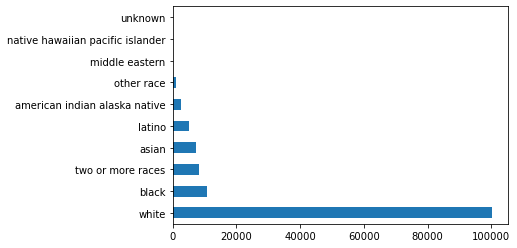

In [44]:
df['race_label'].value_counts().plot(kind='barh');

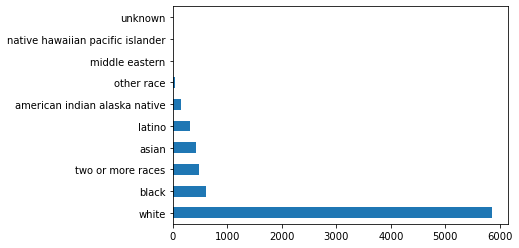

In [53]:
df.groupby('labeler_id')[['labeler_id', 'race_label']].max()['race_label'].value_counts().plot(kind='barh');

In [ ]:
#why did i want to do a pivot table here?
df.pivot_table()

In [58]:
pd.set_option('display.max_colwidth', None)
df[df['comment_id'] == 16176][['comment_id', 'race_label', 'predict_text', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence_phys', 'genocide', 'attack_defend', 'hatespeech' ]]




,comment_id,race_label,predict_text,sentiment,respect,insult,humiliate,status,dehumanize,violence_phys,genocide,attack_defend,hatespeech
6965,16176,other race,Get rid of the blacks . That would solve a lot of porvlems in America,4.0,4.0,2.0,1.0,0.0,1.0,1.0,0.0,3.0,0.0
28457,16176,white,Get rid of the blacks . That would solve a lot of porvlems in America,4.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0
54790,16176,white,Get rid of the blacks . That would solve a lot of porvlems in America,3.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
73947,16176,black,Get rid of the blacks . That would solve a lot of porvlems in America,4.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0


In [59]:
pd.set_option('display.max_colwidth', None)
df[df['comment_id'] == 305][['comment_id', 'race_label', 'predict_text', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence_phys', 'genocide', 'attack_defend', 'hatespeech' ]]




,comment_id,race_label,predict_text,sentiment,respect,insult,humiliate,status,dehumanize,violence_phys,genocide,attack_defend,hatespeech
331,305,white,But how can you kill black teenagers without guns?,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26251,305,white,But how can you kill black teenagers without guns?,4.0,4.0,3.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0
49705,305,white,But how can you kill black teenagers without guns?,4.0,4.0,3.0,2.0,1.0,0.0,1.0,1.0,3.0,0.0
71692,305,black,But how can you kill black teenagers without guns?,4.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0


In [130]:
columns = ['comment_id', 'labeler_id', 'race_label', 'predict_text', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence_phys', 'genocide', 'attack_defend', 'hatespeech' ]
df[(df['target_black'] == 1) & (df['demo_black'] == 1)][columns]

#should we define black as anyone who says black == 1, for the purposes of this analysis?
#bc otherwise grouped under "two or more races" if they put anything else in addition to black
                                    

,comment_id,labeler_id,race_label,predict_text,sentiment,respect,insult,humiliate,status,dehumanize,violence_phys,genocide,attack_defend,hatespeech
210,28228,5673,black,nigga is that a nickel on your forehead URL,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
260,24678,4469,two or more races,racist till you face to face wit a black man 🤦🏿‍♂️ then wanna play victim lmao,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
799,17084,11079,black,We are only commemorating her because she is black.,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
846,12920,656,two or more races,I bet they're gunna be found with bullets in their temples,4.0,4.0,2.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0
1084,34343,5651,black,Get a load of this nigger. URL,4.0,4.0,3.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134342,20066,11094,black,NUGS lauds Ghanaian Muslims for their immense contribution to peace and progess - URL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
134407,20066,967,two or more races,NUGS lauds Ghanaian Muslims for their immense contribution to peace and progess - URL,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
134481,20062,5833,two or more races,I've always been proud of the Igbo tribe and our culture. Yesterday made me even more proud. You people are too fine abeg. #OgbakoUmuIgboDay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
135226,20066,2265,black,NUGS lauds Ghanaian Muslims for their immense contribution to peace and progess - URL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
#which comments targeting black people have the most labelers?
#which labeler_id...

df_black = df[df['target_black']==1][['comment_id', 'labeler_id']]
df_black

,comment_id,labeler_id
0,47777,10873
5,11001,527
20,46526,3863
21,30683,2576
22,15758,8749
...,...,...
135346,20066,346
135381,20062,8220
135415,20066,243
135467,20062,8649


In [77]:
for comment in df_black['comment_id']:
    df_black[df_black['comment_id'] == comment]

In [92]:
#this tells me that for comment 47777 there are two labelers
len(df_black[df_black['comment_id'] == 47777]['labeler_id'])
df_black

,comment_id,labeler_id
0,47777,10873
5,11001,527
20,46526,3863
21,30683,2576
22,15758,8749
...,...,...
135346,20066,346
135381,20062,8220
135415,20066,243
135467,20062,8649


In [93]:
#what's teh question i'm trying to answer?
new_df = df.groupby(by=['comment_id', 'labeler_id']).count()


In [91]:
new_df.loc[(1, [712]), 'sentiment']

comment_id  labeler_id
1           712           1
Name: sentiment, dtype: int64

In [112]:
df_black_count = df_black.pivot_table(index=['comment_id'], values=['labeler_id'], aggfunc='count').sort_values(by='labeler_id', ascending=False)

In [116]:
df_black_count[df_black_count['labeler_id'] > 100]

,labeler_id
comment_id,
20002,798
20001,795
20003,778
20012,764
20045,689
20008,655
20049,650
20015,648
20055,606


In [137]:
#for content targeting black people, these are the comment ids with greater than 100 labelers for each one
comment_ids_g100= df_black_count[df_black_count['labeler_id'] > 100].index.to_list()

df[df['comment_id']==20001]['predict_text']

92327    @Legionary1488 @JomavaesJos now we have a Ebloa case in Texas. If we kill all the niggers we might be safe.
92369    @Legionary1488 @JomavaesJos now we have a Ebloa case in Texas. If we kill all the niggers we might be safe.
92372    @Legionary1488 @JomavaesJos now we have a Ebloa case in Texas. If we kill all the niggers we might be safe.
92378    @Legionary1488 @JomavaesJos now we have a Ebloa case in Texas. If we kill all the niggers we might be safe.
92400    @Legionary1488 @JomavaesJos now we have a Ebloa case in Texas. If we kill all the niggers we might be safe.
                                                            ...                                                     
99899    @Legionary1488 @JomavaesJos now we have a Ebloa case in Texas. If we kill all the niggers we might be safe.
99904    @Legionary1488 @JomavaesJos now we have a Ebloa case in Texas. If we kill all the niggers we might be safe.
99910    @Legionary1488 @JomavaesJos now we have a Ebloa case in

In [149]:
df[df['comment_id'].isin(comment_ids_g100)].groupby(by=['predict_text', 'comment_id']).mean()

,,sentiment,respect,insult,humiliate,status,dehumanize,violence_phys,genocide,attack_defend,hatespeech,...,demo_religion_9,demo_religion_10,demo_sexual_orien_1,demo_sexual_orien_2,demo_sexual_orien_3,demo_sexual_orien_4,demo_sexual_orien_5,demo_ideology,identity,hypothesis
predict_text,comment_id,,,,,,,,,,,,,,,,,,,,,
"""@iamkrause: No need to thank me, killing niggers is it's own reward."" Dis my pal from our graduation when we was 26",20012,3.891786,3.928292,2.764016,1.378096,0.853977,0.749674,0.942634,0.860495,2.661017,0.975228,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.564537,0.753954,0.887065
#whitepower...I'll hang you nigger,20003,3.979461,3.987163,2.878049,1.611040,0.905006,0.740693,0.988447,0.775353,2.913992,0.989730,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.456996,1.000000,0.981482
31 Black Women Who Died In Police Custody URL,20049,2.714286,1.905775,0.474164,0.069909,0.071429,0.045593,0.044073,0.041033,0.870821,0.006079,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.533435,1.000000,0.510388
"@Cam_Coles You don't know what I know. Name somebody colder, you monkey faced immigrant",20014,3.814628,3.858764,2.664565,1.431274,0.894073,0.950820,0.029004,0.005044,2.305170,0.805801,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.363178,1.000000,0.502895
@Legionary1488 @JomavaesJos now we have a Ebloa case in Texas. If we kill all the niggers we might be safe.,20001,3.954944,3.963705,2.866083,1.515645,0.891114,0.755945,0.973717,0.969962,2.866083,0.988736,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.514393,0.753954,0.937652
A black person Acting scared of harmless Animals Just because..... What's new Dramatics are their specialty,20037,3.289003,3.327366,2.191816,0.828645,0.698210,0.337596,0.002558,0.002558,1.928389,0.074169,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.496164,1.000000,0.562623
Black people cant take jokes #bigfacts Here come the I'm racist and downvotes proving this sentiment,20039,3.276808,3.259352,2.032419,0.471322,0.605985,0.174564,0.009975,0.002494,1.900249,0.094763,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.511222,1.000000,0.447715
DO YOU SEE HOW QUICK THE PROSECUTED THAT BLACK COP IN MPLS. MN. FOR KILLING THAT WHITE NIGGA??? GUESS BARR HAND A HAND IN THAT TO HUH. THESE NIGGA'S ARE GONNA GET THEIR DAY!!,20006,3.654667,3.309333,1.910667,0.600000,0.437333,0.332000,0.385333,0.124000,1.857333,0.797333,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.658667,1.000000,0.923075
Fuck you fuck you you stupid cheating [SLUR] bitch go lick a dick and die ur a stupid nigger [SLUR] bitch,20008,3.984722,3.952778,2.791667,1.545833,0.820833,0.701389,0.519444,0.212500,2.643056,0.968056,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.509722,1.000000,0.952183


In [136]:
df[df['comment_id']==20002][columns].groupby(by = ['race_label', 'labeler_id']).mean()

comment_id  sentiment  respect  \
race_label                    labeler_id                                   
american indian alaska native 538              20002        4.0      4.0   
                              1095             20002        4.0      4.0   
                              4259             20002        4.0      4.0   
                              4901             20002        4.0      4.0   
                              5346             20002        4.0      4.0   
...                                              ...        ...      ...   
white                         11069            20002        4.0      4.0   
                              11072            20002        4.0      4.0   
                              11099            20002        4.0      4.0   
                              11106            20002        4.0      4.0   
                              11116            20002        4.0      4.0   

                                          insult  humiliate  status  \
race_label                    labeler_id                              
american indian alaska native 538            3.0        2.0     1.0   
                              1095           3.0        2.0     1.0   
                              4259           3.0        2.0     1.0   
                              4901           3.0        2.0     0.0   
                              5346           3.0        2.0     1.0   
...                                          ...        ...     ...   
white                         11069          3.0        2.0     0.0   
                              11072          3.0        2.0     1.0   
                              11099          3.0        1.0     1.0   
                              11106          3.0        2.0     1.0   
                              11116          3.0        2.0     1.0   

                                          dehumanize  violence_phys  genocide  \
race_label                    labeler_id                                        
american indian alaska native 538                1.0            1.0       1.0   
                              1095               1.0            0.0       0.0   
                              4259               1.0            1.0       1.0   
                              4901               1.0            1.0       1.0   
                              5346               1.0            1.0       1.0   
...                                              ...            ...       ...   
white                         11069              1.0            0.0       0.0   
                              11072              1.0            1.0       1.0   
                              11099              1.0            1.0       1.0   
                              11106              1.0            1.0       1.0   
                              11116              1.0            1.0       1.0   

                                          attack_defend  hatespeech  
race_label                    labeler_id                             
american indian alaska native 538                   3.0         1.0  
                              1095                  3.0         1.0  
                              4259                  3.0         1.0  
                              4901                  3.0         1.0  
                              5346                  3.0         1.0  
...                                                 ...         ...  
white                         11069                 3.0         1.0  
                              11072                 3.0         1.0  
                              11099                 3.0         1.0  
                              11106                 3.0         1.0  
                              11116                 3.0         1.0  

[801 rows x 11 columns]

In [158]:
20039
20043
20002
20062


20062

In [157]:
data_multi[(data_multi['comment_id'] == 20039) & (data_multi['race_label'].isin(['black', 'white']))][columns].pivot_table(index=['race_label', 'predict_text'], values=construct, aggfunc='mean')

,,attack_defend,dehumanize,genocide,hatespeech,humiliate,insult,respect,sentiment,status,violence_phys
race_label,predict_text,,,,,,,,,,
black,Black people cant take jokes #bigfacts Here come the I'm racist and downvotes proving this sentiment,1.560000,0.200000,0.0,0.040000,0.400000,1.760000,2.920000,3.120000,0.400000,0.000000
white,Black people cant take jokes #bigfacts Here come the I'm racist and downvotes proving this sentiment,1.931373,0.173203,0.0,0.094771,0.480392,2.042484,3.261438,3.281046,0.620915,0.003268


In [159]:
data_multi[(data_multi['comment_id'] == 20062) & (data_multi['race_label'].isin(['black', 'white']))][columns].pivot_table(index=['race_label', 'predict_text'], values=construct, aggfunc='mean')

,,attack_defend,dehumanize,genocide,hatespeech,humiliate,insult,respect,sentiment,status,violence_phys
race_label,predict_text,,,,,,,,,,
black,I've always been proud of the Igbo tribe and our culture. Yesterday made me even more proud. You people are too fine abeg. #OgbakoUmuIgboDay,0.560000,0.000000,0.0,0.000000,0.000000,0.020000,0.08000,0.140000,0.020000,0.0
white,I've always been proud of the Igbo tribe and our culture. Yesterday made me even more proud. You people are too fine abeg. #OgbakoUmuIgboDay,0.408397,0.003817,0.0,0.003817,0.003817,0.017176,0.15458,0.211832,0.005725,0.0


In [160]:
data_multi[(data_multi['comment_id'] == 20002) & (data_multi['race_label'].isin(['black', 'white']))][columns].pivot_table(index=['race_label', 'predict_text'], values=construct, aggfunc='mean')

,,attack_defend,dehumanize,genocide,hatespeech,humiliate,insult,respect,sentiment,status,violence_phys
race_label,predict_text,,,,,,,,,,
black,"yeah, heres a clue for the nigger author of this article. Chinks hate niggers, Kikes hate niggers, Spicks hate niggers and Towelheads hate niggers. EVen niggers hate niggers. Black Africans hate the gauche lazy American blacks because they have no morals or work ethic. Niggrus Americanus is the lowest form of human (if you can even call them that) on the planet, we should erase them",2.950820,0.918033,0.852459,1.000000,1.885246,2.836066,3.934426,4.00000,1.000000,0.918033
white,"yeah, heres a clue for the nigger author of this article. Chinks hate niggers, Kikes hate niggers, Spicks hate niggers and Towelheads hate niggers. EVen niggers hate niggers. Black Africans hate the gauche lazy American blacks because they have no morals or work ethic. Niggrus Americanus is the lowest form of human (if you can even call them that) on the planet, we should erase them",2.896211,0.940692,0.822076,0.988468,1.739703,2.934102,3.975288,3.99341,0.967051,0.855025


In [163]:
np.round(data_multi[(data_multi['comment_id'] == 20043) & (data_multi['race_label'].isin(['black', 'white']))][columns].pivot_table(index=['race_label', 'predict_text'], values=construct, aggfunc='mean'), 2)

,,attack_defend,dehumanize,genocide,hatespeech,humiliate,insult,respect,sentiment,status,violence_phys
race_label,predict_text,,,,,,,,,,
black,"im ,i hate black people and minorities",2.21,0.35,0.03,0.41,1.03,2.41,3.76,3.94,0.53,0.09
white,"im ,i hate black people and minorities",2.12,0.33,0.01,0.30,0.78,2.26,3.77,3.86,0.70,0.04


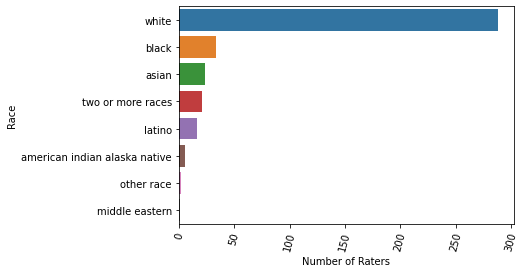

In [178]:
df_20043 = df[df['comment_id'] == 20043]

ax = sns.countplot(y='race_label', data=df_20043, order = df_20043['race_label'].value_counts().index)
labels = ['white', 'asian', 'black', 'latino', 'two or more races', 'american indian alaska native', 'other race', 'native hawaiian pacific islander', 'middle eastern', 'unknown']
          
# ax.set_xticklabels(labels)
ax.set_ylabel('Race')
ax.set_xlabel('Number of Raters')


for name in ax.get_xticklabels(): #notsure what the get_xticklabels does, is it like getcolumnames 
    name.set_rotation(75) 